# Assingment: Advance Regression

## Problem Statement
A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price. For the same purpose, the company has collected a data set from the sale of houses in Australia. The data is provided in the CSV file below.

 

The company is looking at prospective properties to buy to enter the market. You are required to build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not.

 

The company wants to know:

    Which variables are significant in predicting the price of a house, and

    How well those variables describe the price of a house.

 

Also, determine the optimal value of lambda for ridge and lasso regression.

In [1]:
# Importing required libraries
import sys
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split,GridSearchCV,KFold,cross_val_score
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score

warnings.filterwarnings('ignore')
%matplotlib inline

## Step 1: Reading and Understanding the Data

In [2]:
# read the data set
house_price = pd.read_csv('train.csv')

In [3]:
# get the sample records
house_price.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# view all the columns and their datatype
house_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
# get the size of dataset
house_price.shape

(1460, 81)

In [6]:
# find the columns with null values
house_price.columns[house_price.isnull().any()]

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

In [7]:
# get the percentage of null values in the columns
round(house_price.isnull().sum()/len(house_price.index),2).sort_values(ascending=False).head(18)

PoolQC          1.00
MiscFeature     0.96
Alley           0.94
Fence           0.81
FireplaceQu     0.47
LotFrontage     0.18
GarageType      0.06
GarageCond      0.06
GarageYrBlt     0.06
GarageFinish    0.06
GarageQual      0.06
BsmtFinType1    0.03
BsmtExposure    0.03
BsmtCond        0.03
BsmtQual        0.03
BsmtFinType2    0.03
MasVnrArea      0.01
MasVnrType      0.01
dtype: float64

In [8]:
# dropping all coulumns where null values are greater than 10%
columns = ['LotFrontage','Alley','FireplaceQu','PoolQC','Fence','MiscFeature','MoSold']
house_price = house_price.drop(columns,axis='columns')

In [9]:
house_price.shape

(1460, 74)

In [10]:
# get the percentage of missing values in the columns
round(house_price.isnull().sum()/len(house_price.index),2).sort_values(ascending=False).head(18)

GarageType      0.06
GarageYrBlt     0.06
GarageCond      0.06
GarageQual      0.06
GarageFinish    0.06
BsmtFinType1    0.03
BsmtExposure    0.03
BsmtCond        0.03
BsmtQual        0.03
BsmtFinType2    0.03
MasVnrArea      0.01
MasVnrType      0.01
SalePrice       0.00
RoofMatl        0.00
RoofStyle       0.00
Exterior2nd     0.00
Exterior1st     0.00
YearBuilt       0.00
dtype: float64

In [11]:
# create new column and set the age of the house
house_price['YearBuilt_Old'] = house_price.YearBuilt.max()-house_price.YearBuilt

In [12]:
# create new column and set the remodeling age.
house_price['YearRemodAdd_Old'] = house_price.YearRemodAdd.max()-house_price.YearRemodAdd

In [13]:
# create new column and set the age of the garage.
house_price['GarageYrBlt_Old'] = house_price.GarageYrBlt.max()-house_price.GarageYrBlt

In [14]:
# create new columns and set the years last time the house is sold
house_price['YrSold_Old'] = house_price.YrSold.max()-house_price.YrSold

In [15]:
# drop the original columns
house_price = house_price.drop(['YearBuilt','YearRemodAdd','GarageYrBlt','YrSold'],axis='columns')

In [16]:
# get new shape
house_price.shape

(1460, 74)

In [17]:
house_price.head()

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,ScreenPorch,PoolArea,MiscVal,SaleType,SaleCondition,SalePrice,YearBuilt_Old,YearRemodAdd_Old,GarageYrBlt_Old,YrSold_Old
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,WD,Normal,208500,7,7,7.0,2
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,WD,Normal,181500,34,34,34.0,3
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,WD,Normal,223500,9,8,9.0,2
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,WD,Abnorml,140000,95,40,12.0,4
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,WD,Normal,250000,10,10,10.0,2


### Imputing missing values

In [18]:
# get the columns with null values.
round(house_price.isnull().sum()/len(house_price.index),2).sort_values(ascending=False).head(18)

GarageFinish       0.06
GarageCond         0.06
GarageQual         0.06
GarageType         0.06
GarageYrBlt_Old    0.06
BsmtFinType2       0.03
BsmtExposure       0.03
BsmtCond           0.03
BsmtQual           0.03
BsmtFinType1       0.03
MasVnrArea         0.01
MasVnrType         0.01
RoofStyle          0.00
RoofMatl           0.00
Exterior1st        0.00
BsmtFinSF1         0.00
Exterior2nd        0.00
ExterQual          0.00
dtype: float64

In [19]:
# get unique values of GarageFinish
house_price.GarageFinish.value_counts()

Unf    605
RFn    422
Fin    352
Name: GarageFinish, dtype: int64

In [20]:
# imputing GarageFinish
house_price.GarageFinish.fillna('Unf',inplace=True)

In [21]:
# get unique values of GarageCond
house_price.GarageCond.value_counts()

TA    1326
Fa      35
Gd       9
Po       7
Ex       2
Name: GarageCond, dtype: int64

In [22]:
# imputing GarageCond
house_price.GarageCond.fillna('TA',inplace=True)

In [23]:
# get unique values of GarageQual
house_price.GarageQual.value_counts()

TA    1311
Fa      48
Gd      14
Po       3
Ex       3
Name: GarageQual, dtype: int64

In [24]:
# imputing GarageQual
house_price.GarageQual.fillna('TA',inplace=True)

In [25]:
# get unique values of GarageType
house_price.GarageType.value_counts()

Attchd     870
Detchd     387
BuiltIn     88
Basment     19
CarPort      9
2Types       6
Name: GarageType, dtype: int64

In [26]:
# imputing GarageType
house_price.GarageType.fillna('Attchd',inplace=True)

In [27]:
# get unique values of GarageYrBlt_Old
house_price.GarageYrBlt_Old.value_counts()

5.0      65
4.0      59
6.0      53
7.0      50
3.0      49
         ..
83.0      1
110.0     1
102.0     1
104.0     1
77.0      1
Name: GarageYrBlt_Old, Length: 97, dtype: int64

In [28]:
# imputing GarageYrBlt_Old with -1 as these house donot have garage
house_price.GarageYrBlt_Old.fillna(-1,inplace=True)

In [29]:
# get unique values in BsmtFinType2
house_price.BsmtFinType2.value_counts()

Unf    1256
Rec      54
LwQ      46
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64

In [30]:
# imputing 
house_price.BsmtFinType2.fillna('Unf',inplace=True)

In [31]:
# get unique values of BsmtExposure
house_price.BsmtExposure.value_counts()

No    953
Av    221
Gd    134
Mn    114
Name: BsmtExposure, dtype: int64

In [32]:
# imput BsmtExposure
house_price.BsmtExposure.fillna('No',inplace=True)

In [33]:
# get unique values of BsmtCond
house_price.BsmtCond.value_counts()

TA    1311
Gd      65
Fa      45
Po       2
Name: BsmtCond, dtype: int64

In [34]:
# imput BsmtCond
house_price.BsmtCond.fillna('TA',inplace=True)

In [35]:
# get unique values of BsmtQual
house_price.BsmtQual.value_counts()

TA    649
Gd    618
Ex    121
Fa     35
Name: BsmtQual, dtype: int64

In [36]:
# impute BsmtQual
house_price.BsmtQual.fillna('TA',inplace=True)

In [37]:
# get unique values of BsmtFinType1
house_price.BsmtFinType1.value_counts()

Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
Name: BsmtFinType1, dtype: int64

In [38]:
# imput BsmtFinType1
house_price.BsmtFinType1.fillna('Unf',inplace=True)

In [39]:
# get unique values of MasVnrArea
house_price.MasVnrArea.value_counts()

0.0      861
72.0       8
180.0      8
108.0      8
120.0      7
        ... 
651.0      1
337.0      1
415.0      1
293.0      1
621.0      1
Name: MasVnrArea, Length: 327, dtype: int64

In [40]:
# imput MasVnrArea
house_price.MasVnrArea.fillna(house_price.MasVnrArea.mean(),inplace=True)

In [41]:
# get unique values of MasVnrType
house_price.MasVnrType.value_counts()

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

In [42]:
# impute MasVnrType
house_price.MasVnrType.fillna('None',inplace=True)

In [43]:
# get unique values of Street
house_price.Street.value_counts()

Pave    1454
Grvl       6
Name: Street, dtype: int64

In [44]:
# get unique values of Utilities
house_price.Utilities.value_counts()

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

In [45]:
# dropping Street and Utilities columns due to low variance
house_price = house_price.drop(['Street','Utilities'],axis='columns')

In [46]:
# dropping index coulumn
house_price = house_price.drop('Id',axis='columns')

In [47]:
# fetch description of data set
house_price[list(house_price.dtypes[house_price.dtypes!='object'].index)].describe()

,MSSubClass,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,YearBuilt_Old,YearRemodAdd_Old,GarageYrBlt_Old,YrSold_Old
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,10516.828082,6.099315,5.575342,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,...,21.954110,3.409589,15.060959,2.758904,43.489041,180921.195890,38.732192,25.134247,29.691096,2.184247
std,42.300571,9981.264932,1.382997,1.112799,180.569112,456.098091,161.319273,441.866955,438.705324,386.587738,...,61.119149,29.317331,55.757415,40.177307,496.123024,79442.502883,30.202904,20.645407,25.121824,1.328095
min,20.000000,1300.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,34900.000000,0.000000,0.000000,-1.000000,0.000000
25%,20.000000,7553.500000,5.000000,5.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,129975.000000,10.000000,6.000000,7.000000,1.000000
50%,50.000000,9478.500000,6.000000,5.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,163000.000000,37.000000,16.000000,25.500000,2.000000
75%,70.000000,11601.500000,7.000000,6.000000,164.250000,712.250000,0.000000,808.000000,1298.250000,1391.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,214000.000000,56.000000,43.000000,48.000000,3.000000
max,190.000000,215245.000000,10.000000,9.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,...,552.000000,508.000000,480.000000,738.000000,15500.000000,755000.000000,138.000000,60.000000,110.000000,4.000000


### Exploratory Data Analysis

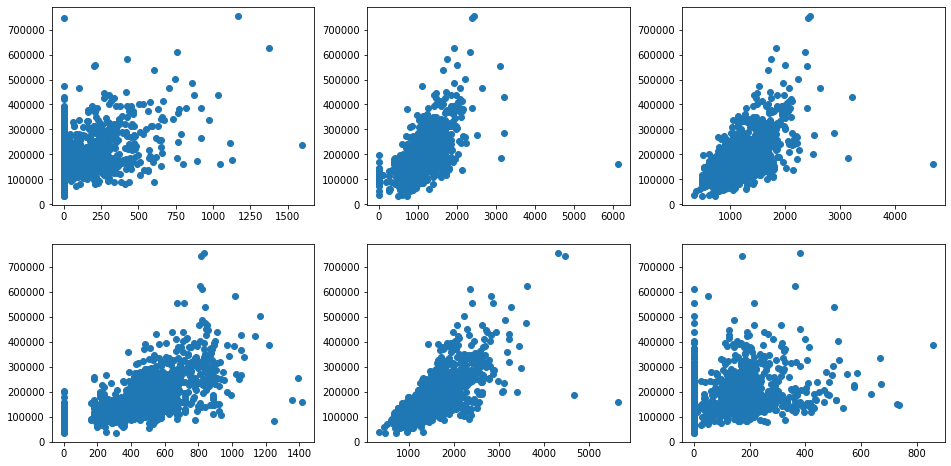

In [48]:
# plotting scatter plots
plt.figure(figsize=(16,8))
plt.subplot(2,3,1)
plt.scatter(house_price.MasVnrArea,house_price.SalePrice)
plt.subplot(2,3,2)
plt.scatter(house_price.TotalBsmtSF,house_price.SalePrice)
plt.subplot(2,3,3)
plt.scatter(house_price['1stFlrSF'],house_price.SalePrice)
plt.subplot(2,3,4)
plt.scatter(house_price['GarageArea'],house_price.SalePrice)
plt.subplot(2,3,5)
plt.scatter(house_price['GrLivArea'],house_price.SalePrice)
plt.subplot(2,3,6)
plt.scatter(house_price['WoodDeckSF'],house_price.SalePrice)

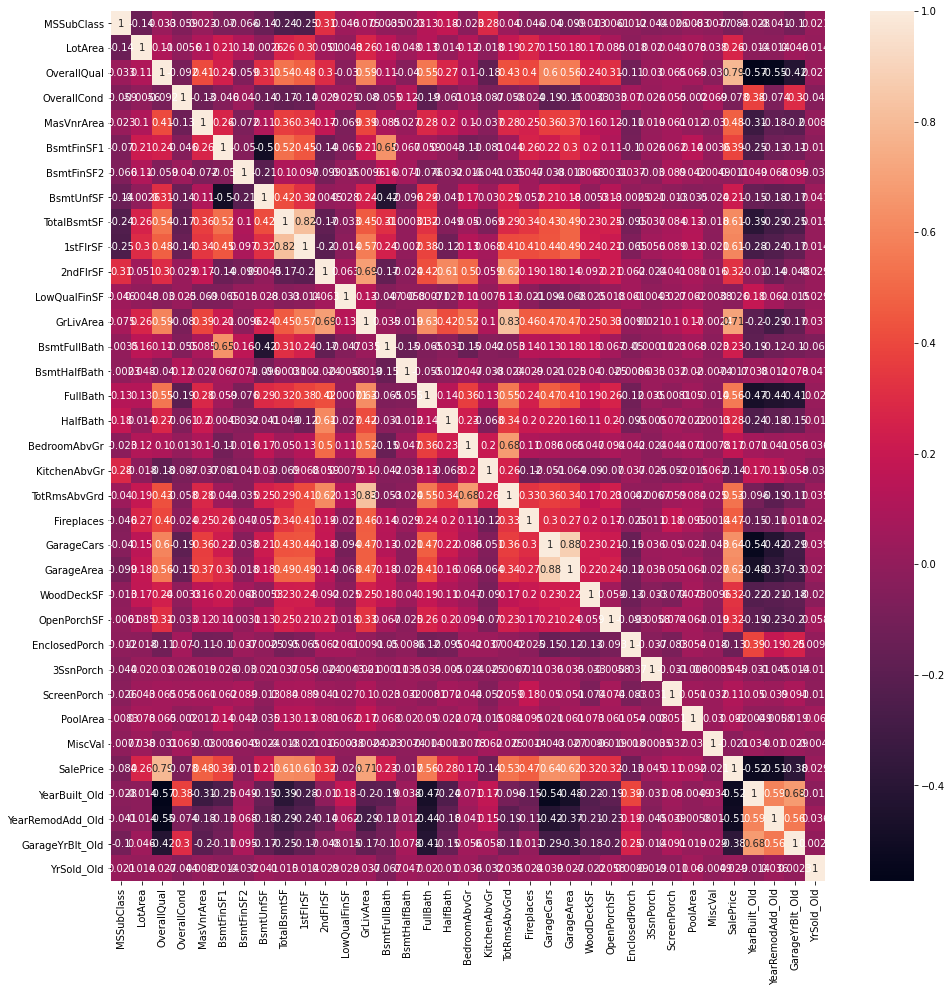

In [49]:
# plotting heatmap to find the multicollinearity
plt.figure(figsize=(16,16))
sns.heatmap(house_price[list(house_price.dtypes[house_price.dtypes!='object'].index)].corr(),annot=True)
plt.show()

In [50]:
# handeling the outliers
# I am taking the lower and upper quantile as 0.25 & 0.99 respectively
num_col = ['LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','TotalBsmtSF','1stFlrSF','GrLivArea','OpenPorchSF',
           'EnclosedPorch','3SsnPorch',
           'ScreenPorch' ,'PoolArea','MiscVal','SalePrice']
def drop_outliers(x):
    list = []
    for col in num_col:
        Q1 = x[col].quantile(.25)
        Q3 = x[col].quantile(.99)
        IQR = Q3-Q1
        x =  x[(x[col] >= (Q1-(1.5*IQR))) & (x[col] <= (Q3+(1.5*IQR)))] 
    return x   

house_price = drop_outliers(house_price)

In [51]:
house_price.head()

,MSSubClass,MSZoning,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,ScreenPorch,PoolArea,MiscVal,SaleType,SaleCondition,SalePrice,YearBuilt_Old,YearRemodAdd_Old,GarageYrBlt_Old,YrSold_Old
0,60,RL,8450,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,...,0,0,0,WD,Normal,208500,7,7,7.0,2
1,20,RL,9600,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,...,0,0,0,WD,Normal,181500,34,34,34.0,3
2,60,RL,11250,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,...,0,0,0,WD,Normal,223500,9,8,9.0,2
3,70,RL,9550,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,...,0,0,0,WD,Abnorml,140000,95,40,12.0,4
4,60,RL,14260,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,...,0,0,0,WD,Normal,250000,10,10,10.0,2


In [52]:
# columns that are ordinal/categorical in nature
house_price[['LandSlope','ExterQual','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
            'HeatingQC','CentralAir',  'KitchenQual','GarageFinish','GarageQual','GarageCond','ExterCond','LotShape']].head()

,LandSlope,ExterQual,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,KitchenQual,GarageFinish,GarageQual,GarageCond,ExterCond,LotShape
0,Gtl,Gd,Gd,TA,No,GLQ,Unf,Ex,Y,Gd,RFn,TA,TA,TA,Reg
1,Gtl,TA,Gd,TA,Gd,ALQ,Unf,Ex,Y,TA,RFn,TA,TA,TA,Reg
2,Gtl,Gd,Gd,TA,Mn,GLQ,Unf,Ex,Y,Gd,RFn,TA,TA,TA,IR1
3,Gtl,TA,TA,Gd,No,ALQ,Unf,Gd,Y,Gd,Unf,TA,TA,TA,IR1
4,Gtl,Gd,Gd,TA,Av,GLQ,Unf,Ex,Y,Gd,RFn,TA,TA,TA,IR1


In [53]:
# mapping the ordinal/categorial columns
house_price['LandSlope'] = house_price.LandSlope.map({'Gtl':0,'Mod':1,'Sev':2})
house_price['ExterQual'] = house_price.ExterQual.map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
house_price['BsmtQual'] = house_price.BsmtQual.map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
house_price['BsmtCond'] = house_price.BsmtCond.map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
house_price['BsmtExposure'] = house_price.BsmtExposure.map({'NA':0,'No':1,'Mn':2,'Av':3,'Gd':4})
house_price['BsmtFinType1'] = house_price.BsmtFinType1.map({'NA':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6})
house_price['BsmtFinType2'] = house_price.BsmtFinType2.map({'NA':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6})
house_price['HeatingQC'] = house_price.HeatingQC.map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
house_price['CentralAir'] = house_price.CentralAir.map({'N':0,'Y':1})
house_price['KitchenQual'] = house_price.KitchenQual.map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
house_price['GarageFinish'] = house_price.GarageFinish.map({'NA':0,'Unf':1,'RFn':2,'Fin':3})
house_price['GarageQual'] = house_price.GarageQual.map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
house_price['GarageCond'] = house_price.GarageCond.map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
house_price['ExterCond'] = house_price.ExterCond.map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
house_price['LotShape'] = house_price.LotShape.map({'IR1':0,'IR2':1,'IR3':2,'Reg':3})

In [54]:
house_price[['LandSlope','ExterQual','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
            'HeatingQC','CentralAir',  'KitchenQual','GarageFinish','GarageQual','GarageCond','ExterCond','LotShape']].head()

,LandSlope,ExterQual,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,KitchenQual,GarageFinish,GarageQual,GarageCond,ExterCond,LotShape
0,0,3,4,3,1,6,1,4,1,3,2,3,3,2,3
1,0,2,4,3,4,5,1,4,1,2,2,3,3,2,3
2,0,3,4,3,2,6,1,4,1,3,2,3,3,2,0
3,0,2,3,4,1,5,1,3,1,3,1,3,3,2,0
4,0,3,4,3,3,6,1,4,1,3,2,3,3,2,0


In [55]:
# creating dummy columns
columns = ['MSZoning','LandContour','LotConfig','Neighborhood','Condition1','Condition2','BldgType',
             'HouseStyle','RoofStyle','RoofMatl','Exterior1st',  'Exterior2nd','MasVnrType','Foundation',
             'Heating','Electrical','Functional','GarageType','PavedDrive','SaleType','SaleCondition']

dummy_col = pd.get_dummies(house_price[columns],drop_first=True)

house_price = pd.concat([house_price,dummy_col],axis='columns')

house_price = house_price.drop(columns,axis='columns')

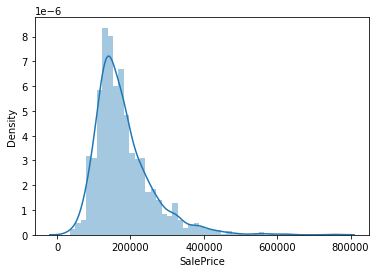

In [56]:
# plotting distplot
sns.distplot(house_price.SalePrice)
plt.show()

In [57]:
# creating training and test data set
df_train,df_test = train_test_split(house_price,train_size=0.7,test_size=0.3,random_state=42)

In [58]:
# scaling the train dataset
num_col = ['MSSubClass','LotArea','OverallQual','OverallCond',
           'MasVnrArea','BsmtFinSF1',
           'BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF',
           'LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr',
           'KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageCars',
           'GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch',
           'ScreenPorch','PoolArea','MiscVal','SalePrice']

scaler = StandardScaler()
df_train[num_col] = scaler.fit_transform(df_train[num_col])
df_test[num_col] = scaler.transform(df_test[num_col])

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

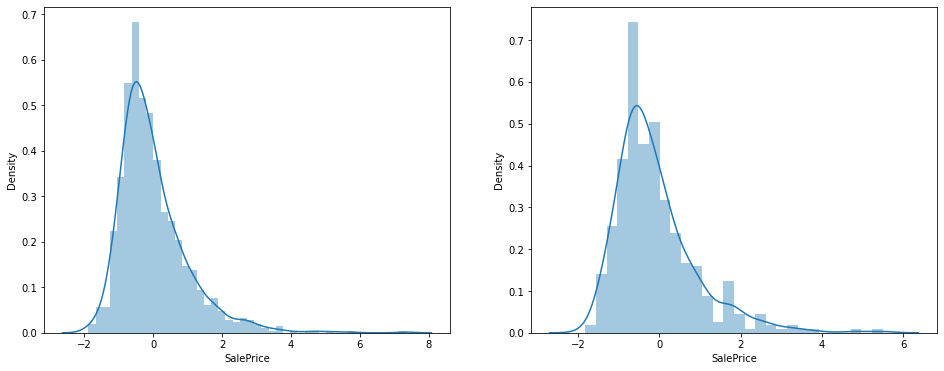

In [59]:
# dist plot again after scaling
plt.figure(figsize=(16,6))
plt.subplot(121)
sns.distplot(df_train.SalePrice)
plt.subplot(122)
sns.distplot(df_test.SalePrice)

In [60]:
y_train = df_train.pop('SalePrice')
X_train = df_train

In [61]:
y_test = df_test.pop('SalePrice')
X_test = df_test

In [62]:
len(X_train.columns)

192

In [63]:
# building the model
lm  = LinearRegression()
lm.fit(X_train,y_train)
rfe = RFE(lm,70)
rfe.fit(X_train,y_train)

RFE(estimator=LinearRegression(), n_features_to_select=70)

In [64]:
rfe_scores = pd.DataFrame(list(zip(X_train.columns,rfe.support_,rfe.ranking_)))
rfe_scores.columns = ['Column_Names','Status','Rank']

In [65]:
rfe_sel_columns = list(rfe_scores[rfe_scores.Status==True].Column_Names)

In [66]:
#  filter the train and test set for the RFE selected columns
X_train = X_train[rfe_sel_columns]
X_test = X_test[rfe_sel_columns]

In [67]:
# Lasso regression model
lm = Lasso(alpha=0.001)
lm.fit(X_train,y_train)

y_train_pred = lm.predict(X_train)
print(r2_score(y_true=y_train,y_pred=y_train_pred))

y_test_pred  = lm.predict(X_test)
print(r2_score(y_true=y_test,y_pred=y_test_pred))

0.8974280093032327
0.8531612222439798


In [68]:
model_parameter = list(lm.coef_)
model_parameter.insert(0,lm.intercept_)
model_parameter = [round(x,3) for x in model_parameter]
col = df_train.columns
col.insert(0,'Constant')
list(zip(col,model_parameter))

[('MSSubClass', -1.186),
 ('LotArea', 0.209),
 ('LotShape', 0.121),
 ('LandSlope', 0.153),
 ('OverallQual', 0.153),
 ('OverallCond', 0.04),
 ('MasVnrArea', -0.0),
 ('ExterQual', 0.067),
 ('ExterCond', 0.0),
 ('BsmtQual', 0.0),
 ('BsmtCond', -0.02),
 ('BsmtExposure', 0.319),
 ('BsmtFinType1', 0.139),
 ('BsmtFinSF1', 0.1),
 ('BsmtFinType2', 0.0),
 ('BsmtFinSF2', 0.0),
 ('BsmtUnfSF', 0.121),
 ('TotalBsmtSF', -0.0),
 ('HeatingQC', -0.05),
 ('CentralAir', 0.191),
 ('1stFlrSF', -0.0),
 ('2ndFlrSF', -0.129),
 ('LowQualFinSF', -0.188),
 ('GrLivArea', -0.055),
 ('BsmtFullBath', -0.079),
 ('BsmtHalfBath', -0.206),
 ('FullBath', -0.232),
 ('HalfBath', -0.196),
 ('BedroomAbvGr', 0.322),
 ('KitchenAbvGr', -0.172),
 ('KitchenQual', -0.093),
 ('TotRmsAbvGrd', -0.118),
 ('Fireplaces', -0.153),
 ('GarageFinish', 0.0),
 ('GarageCars', 0.134),
 ('GarageArea', -0.021),
 ('GarageQual', -0.0),
 ('GarageCond', 0.111),
 ('WoodDeckSF', -2.153),
 ('OpenPorchSF', -0.298),
 ('EnclosedPorch', -0.224),
 ('3SsnPorch

In [69]:
# improve the model with the optimal value of alpha using GridSearchCV
folds = KFold(n_splits=10,shuffle=True,random_state=42)

hyper_param = {'alpha':[0.001, 0.01, 0.1,1.0, 5.0, 10.0,20.0]}

model = Lasso()

model_cv = GridSearchCV(estimator = model,param_grid=hyper_param,scoring='r2',cv=folds,verbose=1,return_train_score=True)

model_cv.fit(X_train,y_train)

Fitting 10 folds for each of 7 candidates, totalling 70 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Lasso(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1.0, 5.0, 10.0, 20.0]},
             return_train_score=True, scoring='r2', verbose=1)

In [70]:
cv_result_l = pd.DataFrame(model_cv.cv_results_)
cv_result_l['param_alpha'] = cv_result_l['param_alpha'].astype('float32')
cv_result_l.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.108352,0.025291,0.008601,0.001673,0.001,{'alpha': 0.001},0.844786,0.905423,0.827806,0.879053,...,0.903401,0.898412,0.895844,0.897181,0.895569,0.909518,0.898525,0.894686,0.898965,0.004358
1,0.025408,0.009951,0.009479,0.002902,0.010,{'alpha': 0.01},0.812610,0.863279,0.835528,0.832886,...,0.847131,0.844850,0.843239,0.842931,0.842151,0.875629,0.845532,0.840392,0.847458,0.009659
2,0.016045,0.006861,0.007736,0.001844,0.100,{'alpha': 0.1},0.737558,0.818260,0.772405,0.755166,...,0.789925,0.797497,0.792001,0.793017,0.787020,0.823363,0.792932,0.787837,0.795240,0.009959
3,0.021643,0.016226,0.008781,0.003318,1.000,{'alpha': 1.0},-0.006496,-0.021566,-0.018063,-0.001154,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.022304,0.010458,0.011922,0.003209,5.000,{'alpha': 5.0},-0.006496,-0.021566,-0.018063,-0.001154,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


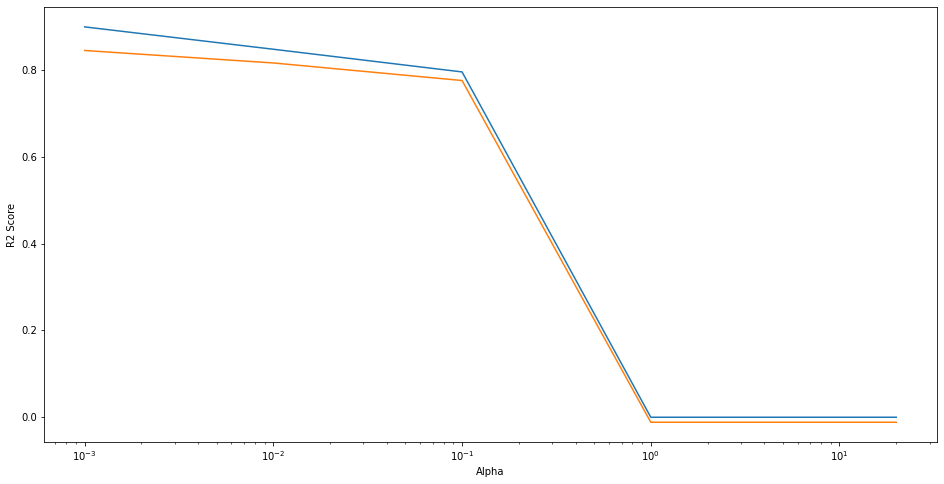

In [71]:
plt.figure(figsize=(16,8))
plt.plot(cv_result_l['param_alpha'],cv_result_l['mean_train_score'])
plt.plot(cv_result_l['param_alpha'],cv_result_l['mean_test_score'])
plt.xscale('log')
plt.ylabel('R2 Score')
plt.xlabel('Alpha')
plt.show()

In [72]:
# Checking the best parameter(Alpha value)
model_cv.best_params_

{'alpha': 0.001}

In [73]:
lasso = Lasso(alpha=0.001)
lasso.fit(X_train,y_train)

y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)

print(r2_score(y_true=y_train,y_pred=y_train_pred))
print(r2_score(y_true=y_test,y_pred=y_test_pred))

0.8974280093032327
0.8531612222439798


In [74]:
model_param = list(lasso.coef_)
model_param.insert(0,lasso.intercept_)
cols = df_train.columns
cols.insert(0,'const')
lasso_coef = pd.DataFrame(list(zip(cols,model_param)))
lasso_coef.columns = ['Featuere','Coef']

In [75]:
lasso_coef.sort_values(by='Coef',ascending=False).head(10)

,Featuere,Coef
46,YearRemodAdd_Old,1.481301
67,Neighborhood_Gilbert,0.334259
28,BedroomAbvGr,0.321613
11,BsmtExposure,0.319103
47,GarageYrBlt_Old,0.211497
1,LotArea,0.208929
19,CentralAir,0.191431
4,OverallQual,0.152887
3,LandSlope,0.152679
60,Neighborhood_Blueste,0.150242


In [76]:
# ridge regression
ridge = Ridge(alpha=0.001)
ridge.fit(X_train,y_train)

y_train_pred = ridge.predict(X_train)
print(r2_score(y_train,y_train_pred))
y_test_pred = ridge.predict(X_test)
print(r2_score(y_test,y_test_pred))

0.9045059654890693
0.8409434949419565


As we can see the above alpha value is not optimal for ridge there are sign of overfitting the clear difference we can see in the train and test score

In [77]:
# improve the model with the optimal value of alpha using GridSearchCV
folds  = KFold(n_splits=10,shuffle=True,random_state=42)

hyper_param = {'alpha':[0.001,0.01,0.1,0.2,0.5,0.9,1.0, 5.0, 10.0,20.0]}

model = Ridge()

model_cv = GridSearchCV(estimator=model,param_grid=hyper_param,scoring='r2',cv=folds,verbose=1,return_train_score=True)

model_cv.fit(X_train,y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 0.2, 0.5, 0.9, 1.0, 5.0,
                                   10.0, 20.0]},
             return_train_score=True, scoring='r2', verbose=1)

In [78]:
cv_result_r = pd.DataFrame(model_cv.cv_results_)
cv_result_r['param_alpha'] = cv_result_r['param_alpha'].astype('float32')
cv_result_r.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.021054,0.009406,0.010618,0.005790,0.001,{'alpha': 0.001},0.846872,0.909169,0.788539,0.884412,...,0.911608,0.906060,0.903557,0.904563,0.903033,0.916150,0.905500,0.901778,0.906270,0.004240
1,0.018809,0.013849,0.011344,0.004797,0.010,{'alpha': 0.01},0.847170,0.909111,0.791371,0.884380,...,0.911605,0.906059,0.903557,0.904562,0.903032,0.916150,0.905499,0.901778,0.906269,0.004240
2,0.031328,0.013922,0.014935,0.009078,0.100,{'alpha': 0.1},0.849250,0.908512,0.814899,0.884074,...,0.911289,0.905979,0.903473,0.904480,0.902945,0.916110,0.905410,0.901695,0.906165,0.004221
3,0.034817,0.011554,0.018133,0.006932,0.200,{'alpha': 0.2},0.850414,0.907822,0.833416,0.883759,...,0.910560,0.905776,0.903261,0.904272,0.902726,0.916011,0.905186,0.901487,0.905910,0.004188
4,0.045930,0.015020,0.024238,0.006666,0.500,{'alpha': 0.5},0.851348,0.905706,0.863219,0.882932,...,0.907592,0.904770,0.902217,0.903248,0.901655,0.915538,0.904095,0.900463,0.904731,0.004157


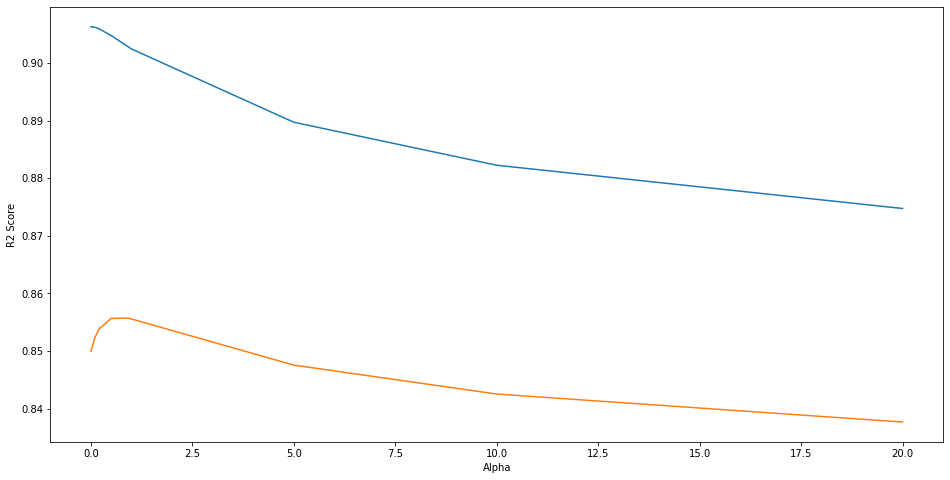

In [79]:
plt.figure(figsize=(16,8))
plt.plot(cv_result_r['param_alpha'],cv_result_r['mean_train_score'])
plt.plot(cv_result_r['param_alpha'],cv_result_r['mean_test_score'])
plt.xlabel('Alpha')
plt.ylabel('R2 Score')
plt.show()

In [80]:
# Checking the best parameter(Alpha value)
model_cv.best_params_

{'alpha': 0.9}

In [81]:
ridge = Ridge(alpha = 0.9)
ridge.fit(X_train,y_train)

y_pred_train = ridge.predict(X_train)
print(r2_score(y_train,y_pred_train))

y_pred_test = ridge.predict(X_test)
print(r2_score(y_test,y_pred_test))

0.9017684728550662
0.8510844293362214


In [82]:
model_parameter = list(ridge.coef_)
model_parameter.insert(0,ridge.intercept_)
cols = df_train.columns
cols.insert(0,'constant')
ridge_coef = pd.DataFrame(list(zip(cols,model_parameter)))
ridge_coef.columns = ['Feaure','Coef']

In [83]:
ridge_coef.sort_values(by='Coef',ascending=False).head(10)

,Feaure,Coef
46,YearRemodAdd_Old,1.477975
67,Neighborhood_Gilbert,0.467746
44,MiscVal,0.313066
68,Neighborhood_IDOTRR,0.291819
28,BedroomAbvGr,0.281409
16,BsmtUnfSF,0.273995
56,LotConfig_CulDSac,0.255498
57,LotConfig_FR2,0.214254
47,GarageYrBlt_Old,0.209753
14,BsmtFinType2,0.202299


After creating model in both Ridge and Lasso we can see that the r2_scores are almost same for both of them but as lasso will penalize more on the dataset and can also help in feature elemination i am goint to consider that as my final model.

**Both Lasso and Ridge have almost sames r2_scores. We can consider Lasso as our final model since it has feature elimination**

In [84]:
# Final Model
lasso = Lasso(alpha=0.001)
lasso.fit(X_train,y_train)

y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)

print(r2_score(y_true=y_train,y_pred=y_train_pred))
print(r2_score(y_true=y_test,y_pred=y_test_pred))

0.8974280093032327
0.8531612222439798


### After compairing both the model we can see that the below Features are best explaining the DataSet

**1. YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)**

**2. Neighborhood => Gilbert: Physical locations within Ames city limits**

**3. MiscVal: $Value of miscellaneous feature**

**4. Neighborhood => IDOTRR: Physical locations within Ames city limits**

**5. BedroomAbvGr:**

**6. BsmtUnfSF: Unfinished square feet of basement area**

Best alpha value for Lasso : {'alpha': 0.001}

Best alpha value for Ridge : {'alpha': 0.9}